In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torchvision.models import RegNet_Y_800MF_Weights
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pandas as pd

In [3]:
# Path to the dataset
data_dir = r'C:\Users\Demyd Zaborskyi\.cache\kagglehub\datasets\itsahmad\indoor-scenes-cvpr-2019\versions\1\indoorCVPR_09\Images'  

# Enhanced Data Augmentation for the training set
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Transforms for the validation and test sets
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load the full dataset
full_dataset = datasets.ImageFolder(root=data_dir, transform=train_transform)

# Split into training, validation, and test sets
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# Apply transforms to validation and test sets
val_dataset.dataset.transform = val_transform
test_dataset.dataset.transform = val_transform

# Data loader parameters
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

num_classes = len(full_dataset.classes)
print(f"Number of classes: {num_classes}")

Number of classes: 67


In [4]:
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    print("GPU not available. Using CPU.")

Using GPU: NVIDIA GeForce RTX 4070


In [5]:
# =========================
# 1. Model with Custom Adapter (Dynamic MultiscaleAdapter)
# =========================

class DynamicMultiscaleAdapter(nn.Module):
    def __init__(self, input_dim, adapter_dim=64, scales=[1, 3, 5]):
        super(DynamicMultiscaleAdapter, self).__init__()
        self.adapters = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(input_dim, adapter_dim, kernel_size=scale, padding=scale // 2),
                nn.ReLU(),
                nn.Dropout(p=0.5),  # Added dropout for regularization
                nn.Conv2d(adapter_dim, input_dim, kernel_size=scale, padding=scale // 2)
            ) for scale in scales
        ])
        self.attention = nn.Conv2d(1, len(scales), kernel_size=1)

    def forward(self, x):
        adapted = [adapter(x) for adapter in self.adapters]
        adapted_stack = torch.stack(adapted, dim=1)  # Shape: (batch_size, num_scales, channels, height, width)

        x_mean = x.mean(dim=1, keepdim=True)  # Shape: (batch_size, 1, height, width)
        scores = self.attention(x_mean)  # Shape: (batch_size, num_scales, height, width)
        weights = torch.softmax(scores, dim=1)  # Shape: (batch_size, num_scales, height, width)

        # Unsqueeze weights to match the channels dimension
        weights = weights.unsqueeze(2)  # Shape: (batch_size, num_scales, 1, height, width)

        adapted = (weights * adapted_stack).sum(dim=1)  # Shape: (batch_size, channels, height, width)
        return x + adapted

class RegNetWithCustomAdapter(nn.Module):
    def __init__(self, base_model, adapter_dim=64, scales=[1, 3, 5]):
        super(RegNetWithCustomAdapter, self).__init__()
        self.base_model = base_model
        self.num_classes = base_model.fc.out_features
        self.base_model.fc = nn.Linear(base_model.fc.in_features, self.num_classes)

        # Add adapters after each block in trunk_output
        self.adapters = nn.ModuleList()
        for i, (name, module) in enumerate(self.base_model.trunk_output.named_children()):
            if isinstance(module, nn.Sequential):
                # Find the last Conv2d layer in the module
                last_conv = None
                for submodule in module.modules():
                    if isinstance(submodule, nn.Conv2d):
                        last_conv = submodule
                if last_conv is not None:
                    input_dim = last_conv.out_channels
                    adapter = DynamicMultiscaleAdapter(input_dim, adapter_dim, scales)
                    self.adapters.append(adapter)
                else:
                    self.adapters.append(None)
            else:
                self.adapters.append(None)

    def forward(self, x):
        x = self.base_model.stem(x)
        for i, (name, module) in enumerate(self.base_model.trunk_output.named_children()):
            x = module(x)
            if self.adapters[i] is not None:
                x = self.adapters[i](x)
        x = self.base_model.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.base_model.fc(x)
        return x

# Load RegNet with custom adapter
weights = RegNet_Y_800MF_Weights.IMAGENET1K_V1
base_regnet = models.regnet_y_800mf(weights=weights)
base_regnet.fc = nn.Linear(base_regnet.fc.in_features, num_classes)
model_custom_adapter = RegNetWithCustomAdapter(base_regnet, adapter_dim=64, scales=[1, 3, 5])

# Freeze all parameters except adapters and the classification layer
for name, param in model_custom_adapter.named_parameters():
    if "adapters" in name or "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

# Unfreeze the last two blocks for fine-tuning
for name, param in model_custom_adapter.base_model.trunk_output.named_parameters():
    if 'block2' in name or 'block3' in name:
        param.requires_grad = True

# Check which parameters will be fine-tuned
print("\nParameters to be fine-tuned (Custom Adapter):")
for name, param in model_custom_adapter.named_parameters():
    if param.requires_grad:
        print(name, param.shape)

# Move the model to the device
model_custom_adapter.to(device)

# Set up the optimizer with weight decay and criterion
criterion_custom = nn.CrossEntropyLoss()
optimizer_custom = optim.Adam(
    filter(lambda p: p.requires_grad, model_custom_adapter.parameters()),
    lr=1e-4,
    weight_decay=1e-5
)

# Learning rate scheduler
scheduler_custom = optim.lr_scheduler.ReduceLROnPlateau(optimizer_custom, mode='min', factor=0.1, patience=2)


Parameters to be fine-tuned (Custom Adapter):
base_model.trunk_output.block1.block1-0.f.se.fc1.weight torch.Size([8, 64, 1, 1])
base_model.trunk_output.block1.block1-0.f.se.fc1.bias torch.Size([8])
base_model.trunk_output.block1.block1-0.f.se.fc2.weight torch.Size([64, 8, 1, 1])
base_model.trunk_output.block1.block1-0.f.se.fc2.bias torch.Size([64])
base_model.trunk_output.block2.block2-0.proj.0.weight torch.Size([144, 64, 1, 1])
base_model.trunk_output.block2.block2-0.proj.1.weight torch.Size([144])
base_model.trunk_output.block2.block2-0.proj.1.bias torch.Size([144])
base_model.trunk_output.block2.block2-0.f.a.0.weight torch.Size([144, 64, 1, 1])
base_model.trunk_output.block2.block2-0.f.a.1.weight torch.Size([144])
base_model.trunk_output.block2.block2-0.f.a.1.bias torch.Size([144])
base_model.trunk_output.block2.block2-0.f.b.0.weight torch.Size([144, 16, 3, 3])
base_model.trunk_output.block2.block2-0.f.b.1.weight torch.Size([144])
base_model.trunk_output.block2.block2-0.f.b.1.bias 

In [6]:
# =========================
# 2. Model with Adapter Tuning
# =========================

class Adapter(nn.Module):
    def __init__(self, input_dim, adapter_dim=64):
        super(Adapter, self).__init__()
        self.conv_down = nn.Conv2d(input_dim, adapter_dim, kernel_size=1)
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)  # Added dropout for regularization
        self.conv_up = nn.Conv2d(adapter_dim, input_dim, kernel_size=1)

    def forward(self, x):
        down = self.conv_down(x)
        activated = self.activation(down)
        dropped = self.dropout(activated)
        up = self.conv_up(dropped)
        return x + up  # Residual connection

class RegNetWithAdapters(nn.Module):
    def __init__(self, base_model, adapter_dim=64):
        super(RegNetWithAdapters, self).__init__()
        self.base_model = base_model
        self.num_classes = base_model.fc.out_features
        self.base_model.fc = nn.Linear(base_model.fc.in_features, self.num_classes)

        # Add adapters after each block in trunk_output
        self.adapters = nn.ModuleList()
        for i, (name, module) in enumerate(self.base_model.trunk_output.named_children()):
            if isinstance(module, nn.Sequential):
                # Find the last Conv2d layer in the module
                last_conv = None
                for submodule in module.modules():
                    if isinstance(submodule, nn.Conv2d):
                        last_conv = submodule
                if last_conv is not None:
                    input_dim = last_conv.out_channels
                    adapter = Adapter(input_dim, adapter_dim)
                    self.adapters.append(adapter)
                else:
                    self.adapters.append(None)
            else:
                self.adapters.append(None)

    def forward(self, x):
        x = self.base_model.stem(x)
        for i, (name, module) in enumerate(self.base_model.trunk_output.named_children()):
            x = module(x)
            if self.adapters[i] is not None:
                x = self.adapters[i](x)
        x = self.base_model.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.base_model.fc(x)
        return x

# Load base RegNet model for Adapter Tuning
weights = RegNet_Y_800MF_Weights.IMAGENET1K_V1
base_model_adapter = models.regnet_y_800mf(weights=weights)
base_model_adapter.fc = nn.Linear(base_model_adapter.fc.in_features, num_classes)

# Initialize model with Adapter Tuning
model_adapter = RegNetWithAdapters(base_model_adapter, adapter_dim=64)

# Freeze all parameters except adapters and the classification layer
for name, param in model_adapter.named_parameters():
    if "adapters" in name or "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

# Unfreeze the last two blocks for fine-tuning
for name, param in model_adapter.base_model.trunk_output.named_parameters():
    if 'block2' in name or 'block3' in name:
        param.requires_grad = True

# Check which parameters will be fine-tuned
print("\nParameters to be fine-tuned (Adapter Tuning):")
for name, param in model_adapter.named_parameters():
    if param.requires_grad:
        print(name, param.shape)

# Move the model to the device
model_adapter.to(device)

# Set up the optimizer with weight decay and criterion
criterion_adapter = nn.CrossEntropyLoss()
optimizer_adapter = optim.Adam(
    filter(lambda p: p.requires_grad, model_adapter.parameters()),
    lr=1e-4,
    weight_decay=1e-5
)

# Learning rate scheduler
scheduler_adapter = optim.lr_scheduler.ReduceLROnPlateau(optimizer_adapter, mode='min', factor=0.1, patience=2)


Parameters to be fine-tuned (Adapter Tuning):
base_model.trunk_output.block1.block1-0.f.se.fc1.weight torch.Size([8, 64, 1, 1])
base_model.trunk_output.block1.block1-0.f.se.fc1.bias torch.Size([8])
base_model.trunk_output.block1.block1-0.f.se.fc2.weight torch.Size([64, 8, 1, 1])
base_model.trunk_output.block1.block1-0.f.se.fc2.bias torch.Size([64])
base_model.trunk_output.block2.block2-0.proj.0.weight torch.Size([144, 64, 1, 1])
base_model.trunk_output.block2.block2-0.proj.1.weight torch.Size([144])
base_model.trunk_output.block2.block2-0.proj.1.bias torch.Size([144])
base_model.trunk_output.block2.block2-0.f.a.0.weight torch.Size([144, 64, 1, 1])
base_model.trunk_output.block2.block2-0.f.a.1.weight torch.Size([144])
base_model.trunk_output.block2.block2-0.f.a.1.bias torch.Size([144])
base_model.trunk_output.block2.block2-0.f.b.0.weight torch.Size([144, 16, 3, 3])
base_model.trunk_output.block2.block2-0.f.b.1.weight torch.Size([144])
base_model.trunk_output.block2.block2-0.f.b.1.bias 

In [7]:
# =========================
# Functions for Training and Evaluation with Early Stopping
# =========================

def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10, model_name='model', architecture_name='', scheduler=None):
    best_val_acc = 0.0
    total_training_time = 0.0  # Variable to store total training time

    # Early Stopping parameters
    patience = 3  # Number of epochs to wait without improvement
    best_val_loss = float('inf')
    epochs_no_improve = 0

    # Lists to store losses and accuracies
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        start_time = time.time()  # Start time measurement for the epoch

        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            logits = outputs

            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(logits, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                logits = outputs

                loss = criterion(logits, labels)

                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(logits, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_epoch_loss = val_loss / len(val_loader.dataset)
        val_epoch_acc = val_correct / val_total

        val_losses.append(val_epoch_loss)
        val_accuracies.append(val_epoch_acc)

        # Step the scheduler
        if scheduler is not None:
            scheduler.step(val_epoch_loss)

        end_time = time.time()  # End time measurement for the epoch
        epoch_time = end_time - start_time
        total_training_time += epoch_time

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f} | "
              f"Val Loss: {val_epoch_loss:.4f} | Val Acc: {val_epoch_acc:.4f} | "
              f"Time: {epoch_time:.2f}s")

        # Early Stopping Check
        if val_epoch_loss < best_val_loss:
            best_val_loss = val_epoch_loss
            epochs_no_improve = 0
            # Save the best model
            torch.save(model.state_dict(), f'best_{model_name}_{architecture_name}.pth')
            best_val_acc = val_epoch_acc
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print('Early stopping!')
                break

    print(f"Best Validation Accuracy for {model_name}: {best_val_acc:.4f}")
    print(f"Total Training Time for {model_name}: {total_training_time:.2f}s")
    return total_training_time, train_losses, val_losses, train_accuracies, val_accuracies  # Return training metrics

def evaluate_model(model, test_loader, device, class_names, model_name='model'):
    model.eval()
    all_preds = []
    all_labels = []
    inference_times = []  # List to store inference times

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            start_time = time.time()  # Start time measurement for inference
            outputs = model(inputs)
            end_time = time.time()  # End time measurement for inference

            logits = outputs

            _, preds = torch.max(logits, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            inference_times.append(end_time - start_time)

    acc = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    avg_inference_time = sum(inference_times) / len(inference_times)

    print(f"\nTest Metrics for {model_name}:")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Average Inference Time per Batch: {avg_inference_time:.4f}s")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

    return acc, precision, recall, f1, avg_inference_time, cm

def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

In [8]:
# Training the model with Custom Adapter
print("\n=== Training model with Custom Adapter ===")
training_time_custom_adapter, train_losses_custom, val_losses_custom, train_accuracies_custom, val_accuracies_custom = train_model(
    model=model_custom_adapter,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion_custom,
    optimizer=optimizer_custom,
    device=device,
    num_epochs=10,  # Increased epochs
    model_name='model_custom_adapter',
    architecture_name='RegNet',
    scheduler=scheduler_custom
)



=== Training model with Custom Adapter ===
Epoch 1/10 | Train Loss: 2.4431 | Train Acc: 0.3812 | Val Loss: 1.4884 | Val Acc: 0.5753 | Time: 45.32s
Epoch 2/10 | Train Loss: 1.1079 | Train Acc: 0.6768 | Val Loss: 1.1313 | Val Acc: 0.6564 | Time: 44.27s
Epoch 3/10 | Train Loss: 0.6663 | Train Acc: 0.7955 | Val Loss: 0.9373 | Val Acc: 0.7119 | Time: 44.63s
Epoch 4/10 | Train Loss: 0.4059 | Train Acc: 0.8699 | Val Loss: 0.9610 | Val Acc: 0.7234 | Time: 44.14s
Epoch 5/10 | Train Loss: 0.2465 | Train Acc: 0.9212 | Val Loss: 1.0868 | Val Acc: 0.7093 | Time: 44.89s
Epoch 6/10 | Train Loss: 0.1647 | Train Acc: 0.9457 | Val Loss: 1.1201 | Val Acc: 0.7204 | Time: 44.77s
Early stopping!
Best Validation Accuracy for model_custom_adapter: 0.7119
Total Training Time for model_custom_adapter: 268.01s


In [9]:
# Training the model with Adapter Tuning
print("\n=== Training model with Adapter Tuning ===")
training_time_adapter, train_losses_adapter, val_losses_adapter, train_accuracies_adapter, val_accuracies_adapter = train_model(
    model=model_adapter,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion_adapter,
    optimizer=optimizer_adapter,
    device=device,
    num_epochs=30,  # Increased epochs
    model_name='model_adapter',
    architecture_name='RegNet',
    scheduler=scheduler_adapter
)


=== Training model with Adapter Tuning ===
Epoch 1/30 | Train Loss: 3.0509 | Train Acc: 0.2768 | Val Loss: 2.0496 | Val Acc: 0.4750 | Time: 44.84s
Epoch 2/30 | Train Loss: 1.5614 | Train Acc: 0.5867 | Val Loss: 1.3070 | Val Acc: 0.6210 | Time: 44.30s
Epoch 3/30 | Train Loss: 0.9701 | Train Acc: 0.7350 | Val Loss: 1.0713 | Val Acc: 0.6850 | Time: 44.99s
Epoch 4/30 | Train Loss: 0.6296 | Train Acc: 0.8283 | Val Loss: 0.9775 | Val Acc: 0.7119 | Time: 44.69s
Epoch 5/30 | Train Loss: 0.3930 | Train Acc: 0.8959 | Val Loss: 1.0054 | Val Acc: 0.7072 | Time: 44.37s
Epoch 6/30 | Train Loss: 0.2381 | Train Acc: 0.9411 | Val Loss: 1.0491 | Val Acc: 0.7106 | Time: 44.71s
Epoch 7/30 | Train Loss: 0.1700 | Train Acc: 0.9612 | Val Loss: 1.0699 | Val Acc: 0.7042 | Time: 45.11s
Early stopping!
Best Validation Accuracy for model_adapter: 0.7119
Total Training Time for model_adapter: 313.01s


# Evaluating the models

In [10]:
class_names = full_dataset.classes


=== Evaluating model with Custom Adapter ===

Test Metrics for Custom Adapter:
Accuracy: 0.7217
Precision: 0.7361
Recall: 0.7217
F1-Score: 0.7181
Average Inference Time per Batch: 0.0071s


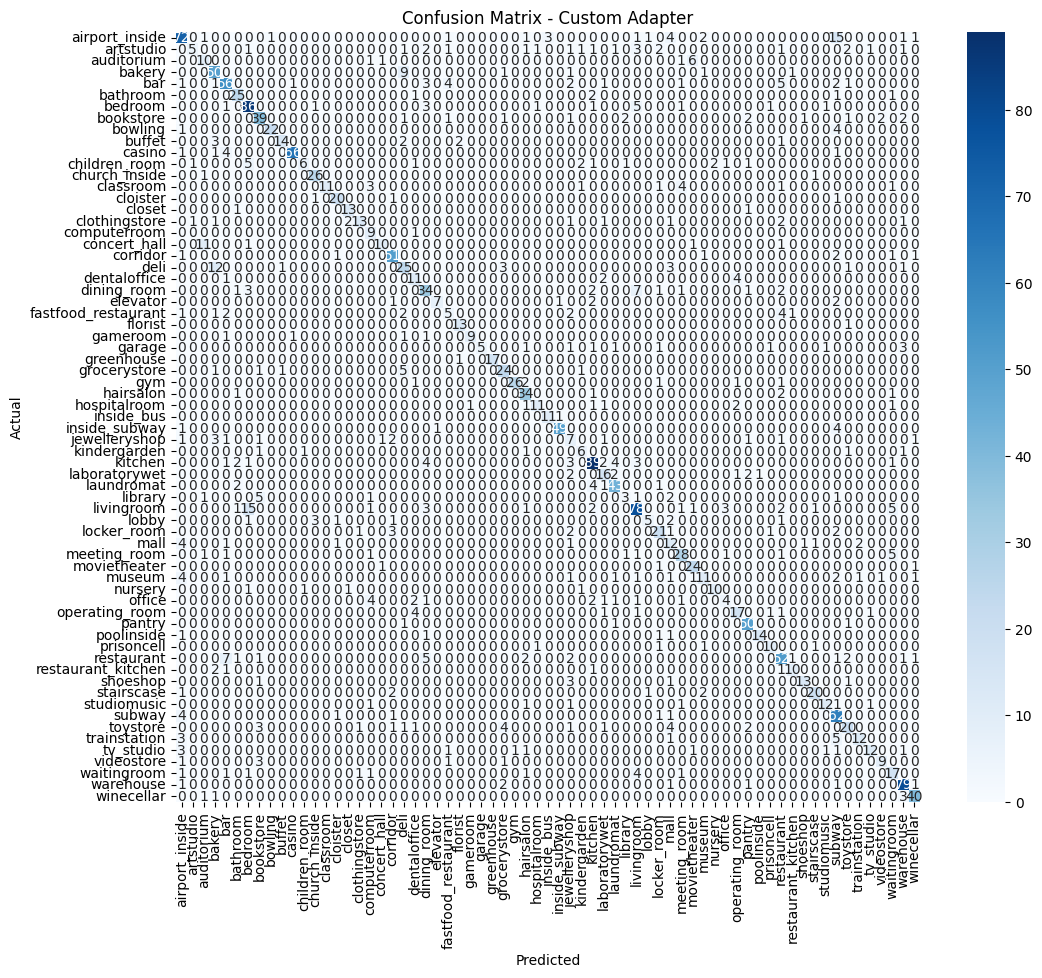

In [11]:
# Evaluating the model with Custom Adapter
print("\n=== Evaluating model with Custom Adapter ===")
model_custom_adapter.load_state_dict(torch.load('best_model_custom_adapter_RegNet.pth'))
model_custom_adapter.to(device)
acc_custom_adapter, precision_custom_adapter, recall_custom_adapter, f1_custom_adapter, inference_time_custom_adapter, cm_custom_adapter = evaluate_model(
    model=model_custom_adapter,
    test_loader=test_loader,
    device=device,
    class_names=class_names,
    model_name='Custom Adapter'
)

In [12]:
# Counting parameters of the Custom Adapter model
total_params_custom_adapter, trainable_params_custom_adapter = count_parameters(model_custom_adapter)
print(f"\nCustom Adapter Model - Total Parameters: {total_params_custom_adapter}, Trainable Parameters: {trainable_params_custom_adapter}")



Custom Adapter Model - Total Parameters: 11582595, Trainable Parameters: 8981251



=== Evaluating model with Adapter Tuning ===

Test Metrics for Adapter Tuning:
Accuracy: 0.7166
Precision: 0.7299
Recall: 0.7166
F1-Score: 0.7102
Average Inference Time per Batch: 0.0061s


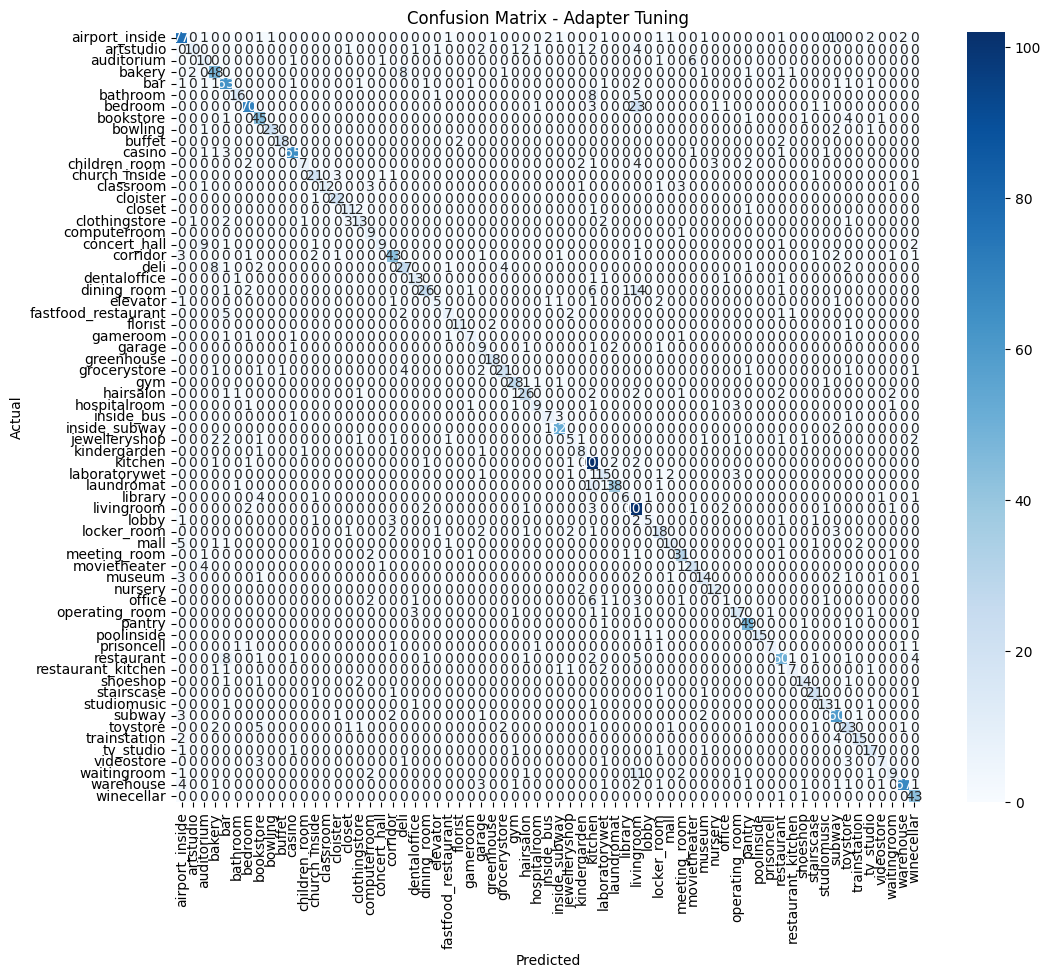

In [13]:
# Evaluating the model with Adapter Tuning
print("\n=== Evaluating model with Adapter Tuning ===")
model_adapter.load_state_dict(torch.load('best_model_adapter_RegNet.pth'))
model_adapter.to(device)
acc_adapter, precision_adapter, recall_adapter, f1_adapter, inference_time_adapter, cm_adapter = evaluate_model(
    model=model_adapter,
    test_loader=test_loader,
    device=device,
    class_names=class_names,
    model_name='Adapter Tuning'
)

In [14]:
# Counting parameters of the Adapter Tuning model
total_params_adapter, trainable_params_adapter = count_parameters(model_adapter)
print(f"\nAdapter Tuning Model - Total Parameters: {total_params_adapter}, Trainable Parameters: {trainable_params_adapter}")


Adapter Tuning Model - Total Parameters: 5869611, Trainable Parameters: 3268267


In [15]:
# Creating a summary table with results
data = {
    'Model': ['Custom Adapter', 'Adapter Tuning'],
    'Accuracy': [acc_custom_adapter, acc_adapter],
    'Precision': [precision_custom_adapter, precision_adapter],
    'Recall': [recall_custom_adapter, recall_adapter],
    'F1-Score': [f1_custom_adapter, f1_adapter],
    'Training Time (s)': [training_time_custom_adapter, training_time_adapter],
    'Inference Time (s)': [inference_time_custom_adapter, inference_time_adapter],
    'Total Params': [total_params_custom_adapter, total_params_adapter],
    'Trainable Params': [trainable_params_custom_adapter, trainable_params_adapter],
}

In [16]:
df_results = pd.DataFrame(data)
print("\nComparison of model results:")
print(df_results)


Comparison of model results:
            Model  Accuracy  Precision    Recall  F1-Score  Training Time (s)  \
0  Custom Adapter  0.721724   0.736111  0.721724  0.718135         268.014721   
1  Adapter Tuning  0.716603   0.729907  0.716603  0.710161         313.010502   

   Inference Time (s)  Total Params  Trainable Params  
0            0.007104      11582595           8981251  
1            0.006104       5869611           3268267  


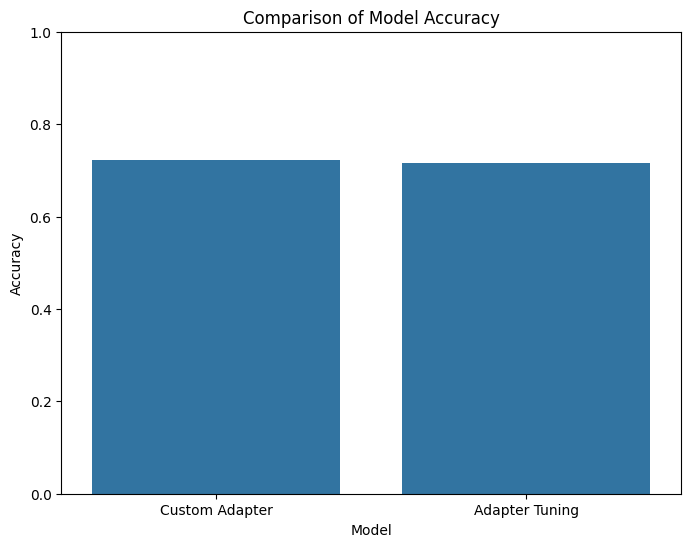

In [17]:
# Comparing Accuracy
plt.figure(figsize=(8, 6))
sns.barplot(x='Model', y='Accuracy', data=df_results)
plt.title('Comparison of Model Accuracy')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()

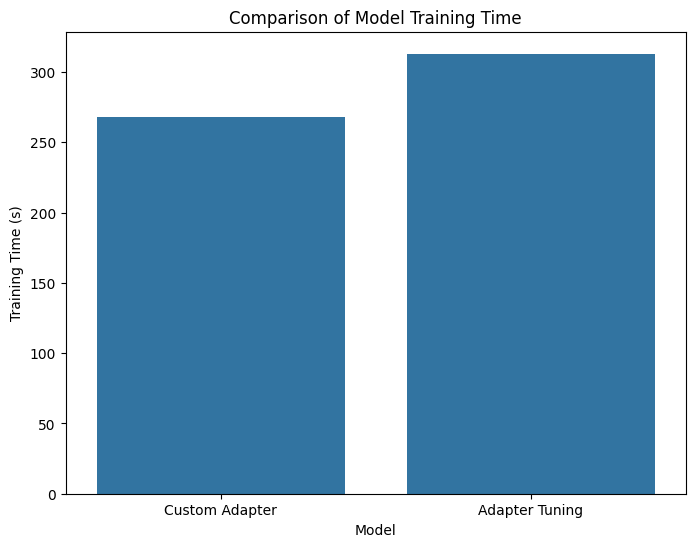

In [18]:
# Comparing Training Time
plt.figure(figsize=(8, 6))
sns.barplot(x='Model', y='Training Time (s)', data=df_results)
plt.title('Comparison of Model Training Time')
plt.ylabel('Training Time (s)')
plt.show()

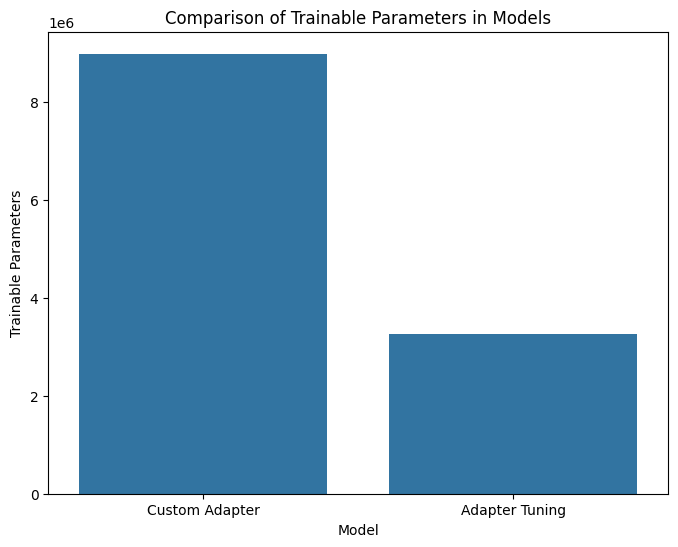

In [19]:
# Comparing Number of Trainable Parameters
plt.figure(figsize=(8, 6))
sns.barplot(x='Model', y='Trainable Params', data=df_results)
plt.title('Comparison of Trainable Parameters in Models')
plt.ylabel('Trainable Parameters')
plt.show()